## Volumetric Survey Speed: A Figure of Merit for Transient Surveys

Code to generate the figures from Bellm 2016, PASP

In [2]:
import numpy as N
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sb
import shelve, pickle
import cosmolopy as cp
%matplotlib inline

In [3]:
from Cadence import *
from Survey import *

In [10]:
# aesthetics
sb.set_style('white')
sb.set_style('ticks')
#sb.set_context('talk') # takes default font sizes up by 1.3, replacing below
mpl.rcParams['figure.figsize'] = (8,6) # but need to revert the canvas size
# I think I prefer larger labels and thinner lines than set_context('talk') gives
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 14

# hardcopy figures
plot_dir = './fig/'
plot_dirnofig = './'


def outside_legend(ax=None):
    # Shink current axis by 20%
    if ax is None:
        ax=plt.gca()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    return lgd

In [5]:
cp.parameters.WMAP7_BAO_H0_mean()
cp.fidcosmo

{'N_nu': 0,
 'Y_He': 0.24,
 'h': 0.704,
 'n': 0.963,
 'omega_M_0': 0.2726,
 'omega_b_0': 0.0456,
 'omega_k_0': 0.0,
 'omega_lambda_0': 0.7274,
 'omega_n_0': 0.0,
 'sigma_8': 0.809,
 't_0': 13.75,
 'tau': 0.087,
 'z_reion': 10.4}

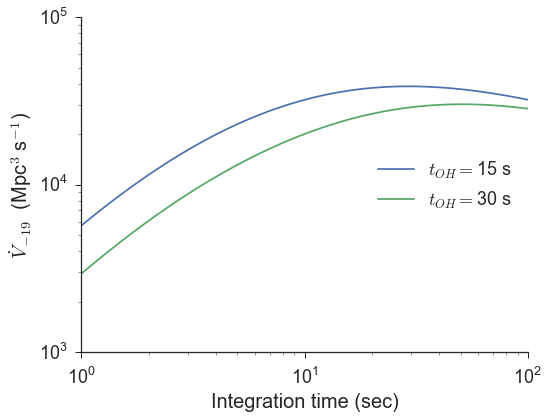

In [7]:
#FIGURE 1: vdot_vs_texp.pdf
# optimum exposure time
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['legend.fontsize'] = 18
volumetric_survey_rate(-19,47,2,label='$t_{OH} = $15 s')
volumetric_survey_rate(-19,47,2,slew_time=30,label='$t_{OH} = $30 s')
plt.ylabel('$\dot{V}_{-19}$  (Mpc$^3$ s$^{-1}$)')
plt.legend(loc='center right')
sb.despine()
plt.savefig(plot_dir + 'vdot_vs_texp.pdf')

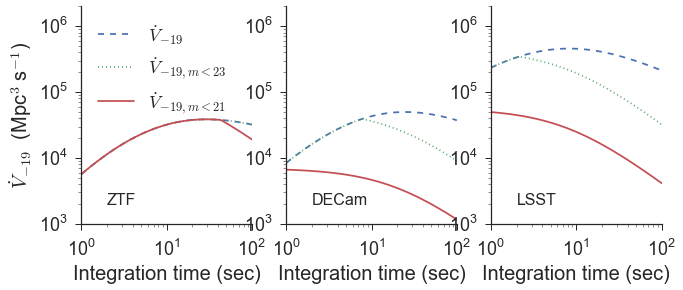

In [8]:
#FIGURE 2
from Telescope import Blanco, LSST
from Camera import DECam, LSST_cam
adjust=0.65
mpl.rcParams['figure.figsize'] = (16*adjust,6*adjust)
abs_mag = -19
plt.subplot(131)
# ZTF
_=  volumetric_survey_rate(abs_mag,47,2,ls='--',label='$\dot{V}_{-19}$')
_=  volumetric_survey_rate(abs_mag,47,2,max_lim_mag=23,ls=':',label='$\dot{V}_{-19,m<23}$')
_=  volumetric_survey_rate(abs_mag,47,2,max_lim_mag=21,label='$\dot{V}_{-19,m<21}$')
plt.legend(loc=2)
plt.ylabel('$\dot{V}_{-19}$  (Mpc$^3$ s$^{-1}$)')
plt.ylim(1e3,2e6)
plt.text(2,2e3,'ZTF')
plt.subplot(132)
#DECAM
# need a better reference for FWHM=
# sky estimate from http://www.ctio.noao.edu/noao/content/Night-Sky-Background
_=  volumetric_survey_rate(abs_mag,3,0.8,ls='--', slew_time=20, sky_brightness=21.4, telescope=Blanco, camera=DECam, filterkey='DESr')
_=  volumetric_survey_rate(abs_mag,3,0.8,max_lim_mag=23, slew_time=20, ls=':', sky_brightness =21.4, telescope=Blanco, camera=DECam, filterkey='DESr')
_=  volumetric_survey_rate(abs_mag,3,0.8,max_lim_mag=21, slew_time=20, sky_brightness=21.4, telescope=Blanco, camera=DECam, filterkey='DESr')
plt.ylabel('')
plt.ylim(1e3,2e6)
plt.text(2,2e3,'DECam')
sb.despine()
plt.subplot(133)
#LSST
# overhead: 1 sec shutter, 2 sec read, 5 sec slew
_=  volumetric_survey_rate(abs_mag,9.6,0.7,ls='--', slew_time=8, sky_brightness=21, telescope=LSST, camera=LSST_cam, filterkey='LSSTr')
_=  volumetric_survey_rate(abs_mag,9.6,0.7,max_lim_mag=23, slew_time=8, ls=':', sky_brightness =21, telescope=LSST, camera=LSST_cam, filterkey='LSSTr')
_=  volumetric_survey_rate(abs_mag,9.6,0.7,max_lim_mag=21, slew_time=8, sky_brightness=21, telescope=LSST, camera=LSST_cam, filterkey='LSSTr')
plt.ylabel('')
plt.ylim(1e3,2e6)
plt.text(2,2e3,'LSST')
sb.despine()
mpl.rcParams['figure.figsize'] = (8,6)
plt.savefig(plot_dir + 'spec_vdot_by_telescope.pdf',bbox_inches='tight')

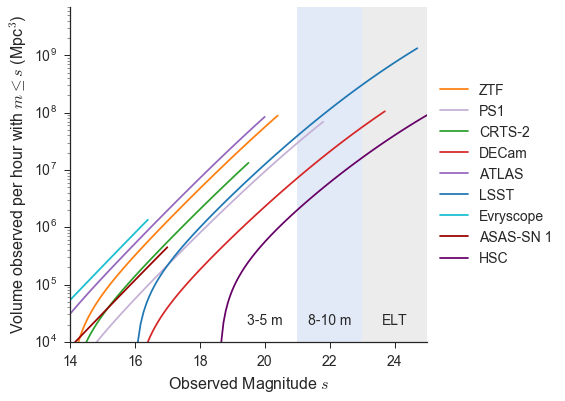

In [11]:
#FIGURE 3
import matplotlib.patches as mpatches

per_hour = True
    
use = ['ZTF','PS1','CRTS-2','DECam','LSST','HSC','Evryscope','ATLAS','ASAS-SN 1']
use_surveys = [s for s in surveys if s.name in use]

abs_mag = -19
fig = plt.figure()
ax = plt.subplot(111)
for s in use_surveys:
    if per_hour and s.name == 'EvryScope':
        lm = 18.2
    else:
        lm = s.limiting_mag
        
    mags = N.linspace(s.saturation,lm,100)
    
    vdot = N.array([unweighted_survey_speed(abs_mag,m,s.fov,(s.optimal_exposure+s.overhead)) for m in mags])

    if per_hour:
        # make this per hour
        if s.name != 'Evryscope':
            vdot *= 3600.
        else:
            # volume covered in one exposure
            vdot *= s.optimal_exposure+s.overhead
    plt.plot(mags,vdot-vdot[0],label=s.name, color=s.color)

    

xl = [10,25]
yl = [1e0,2e6]   
if per_hour:
    xl = [14,25]
    yl = [1e4,7e9]
    
palette = sb.color_palette('muted')
rect = mpatches.Rectangle([21,yl[0]] ,2, yl[1]-yl[0], ec="none",facecolor=palette[0],alpha=0.15)
ax.add_patch(rect)
rect = mpatches.Rectangle([23,yl[0]] ,2, yl[1]-yl[0], ec="none",facecolor='grey',alpha=0.15)
ax.add_patch(rect)
plt.text(20,yl[0]*2, '3-5 m',ha='center',  size=14)
plt.text(22,yl[0]*2, '8-10 m',ha='center',  size=14)
plt.text(24,yl[0]*2, 'ELT',ha='center',  size=14)

plt.yscale('log')
plt.xlabel('Observed Magnitude $s$')
if per_hour:
    plt.ylabel('Volume observed per hour with $m \leq s$ (Mpc$^3$)')
else:
    plt.ylabel('Volume observed per second with $m \leq s$ (Mpc$^3$ s$^{-1}$)')
plt.xlim(xl[0],xl[1])
plt.ylim(yl[0],yl[1])
sb.despine()
outside_legend()
if per_hour:
    plt.savefig(plot_dir+'Volume_per_hour_vs_observed_mag.pdf',bbox_inches='tight')
else:
    plt.savefig(plot_dir+'Volume_per_sec_vs_observed_mag.pdf',bbox_inches='tight')

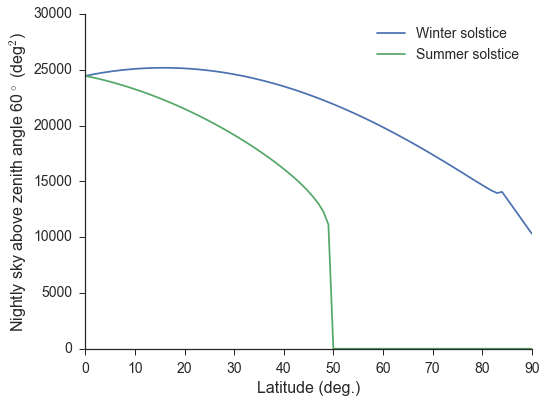

In [12]:
#FIGURE 4
# max and min unique sky per night, by latitude
# bump at lat=84 degrees is increment to 24 hours of darkness
za = 60
lats = N.arange(91)
plt.plot(lats,[unique_sky_per_night(lat,za,hours_of_darkness(0,latitude=lat)) for lat in lats],label='Winter solstice')
plt.plot(lats,[unique_sky_per_night(lat,za,hours_of_darkness(183,latitude=lat)) for lat in lats],label='Summer solstice')
plt.xlabel('Latitude (deg.)')
plt.ylabel('Nightly sky above zenith angle {}$^\circ$ (deg$^2$)'.format(za))
plt.legend()
sb.despine()
plt.savefig(plot_dir+'unique_sky_per_night.pdf')

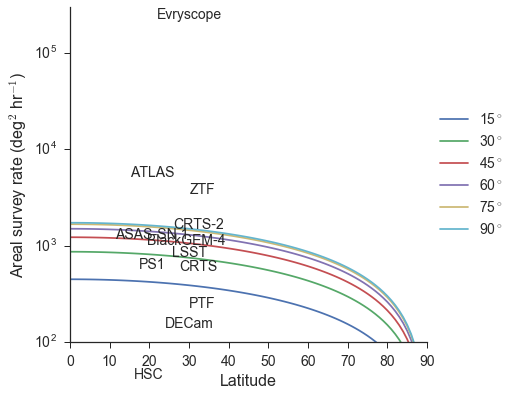

In [13]:
# FIGURE 5
zas = [15, 30, 45, 60, 75, 90]
lats = N.arange(91)
for za in zas:
    plt.plot(lats,[dsky_dt(lat,za)*3600 for lat in lats],label=str(za)+'$^\circ$')
#fsidereal = (DAY2SEC - SIDEREAL_DAY_SEC)/DAY2SEC
#plt.plot(lats,[dsky_dt(lat,90)*3600*fsidereal for lat in lats],'--',label='90$^\circ$ (sidereal)')
plt.xlabel('Latitude')
#plt.ylabel('Rate of change of accessible sky (deg$^2$/hr)')
plt.ylabel('Areal survey rate (deg$^2$ hr$^{-1}$)')
plt.xlim(0,90)
outside_legend()
sb.despine()

for survey in surveys:
    if survey.name in ['PS1 & 2']:
        continue
    areal_rate = survey.areal_survey_rate()*3600.
    plt.text(survey.lat, areal_rate, survey.name, ha='center', va='center', size=14)


plt.yscale('symlog')
plt.ylim(1e2,3e5)
# have to tell savefig to use tight layout to get the keep the legend from being cut off
# http://stackoverflow.com/questions/10101700/moving-matplotlib-legend-outside-of-the-axis-makes-it-cutoff-by-the-figure-box
plt.savefig(plot_dir+'areal_survey_rate_vs_footprint_rotation.pdf',bbox_inches='tight')

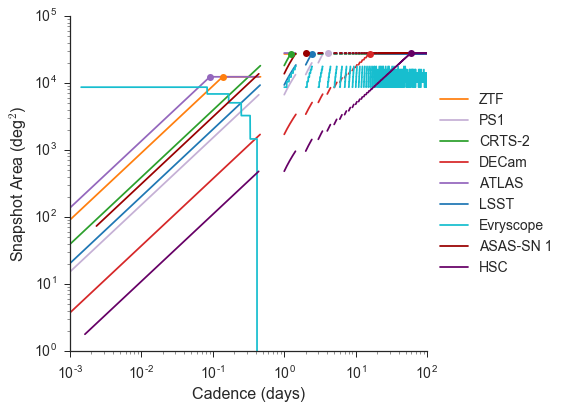

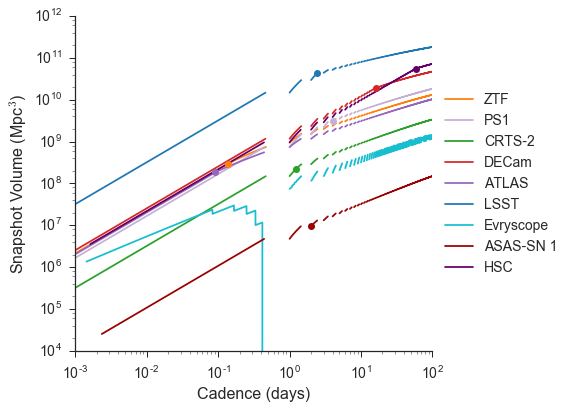

In [25]:
#FIGURE 6 and 7 (set max_mlim=21)
# 2 minutes to 100 days
# need 5000 points (and some patience) to avoid aliasing
cadence_times_days = N.logspace(-3,2,5000)
#cadence_times_days = N.logspace(-3,2,100)
use = ['ZTF','PS1','CRTS-2','DECam','LSST','Evryscope','ATLAS', 'ASAS-SN 1','HSC']
use_surveys = [s for s in surveys if s.name in use]

abs_mag = -19
max_mlim = None
fig1 = plt.figure()
ax1 = plt.subplot(111)
fig2 = plt.figure()
ax2 = plt.subplot(111)
for s in use_surveys:
    #a, b = zip(*[func(i,j) for i, j in zip(x,y)])
    area, vol, mlim = zip(*[s.snapshot_size(t,absolute_mag=abs_mag, max_mlim = max_mlim) for t in cadence_times_days])
    ax1.plot(cadence_times_days,area,label=s.name, color=s.color)
    ax2.plot(cadence_times_days,vol,label=s.name, color=s.color)

for s in use_surveys:
    if s.name != 'Evryscope':
        tlim, _ = s.sky_limited_cadence()
        area, vol, mlim = s.snapshot_size(tlim,absolute_mag=abs_mag, max_mlim = max_mlim)
        ax1.plot(tlim,area,'o',color=s.color)
        ax2.plot(tlim,vol,'o',color=s.color)
    
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Cadence (days)')
ax1.set_ylabel('Snapshot Area (deg$^2$)')

sb.despine(fig1)
outside_legend(ax=ax1)
fig1.savefig(plot_dir+'Snapshot_area_vs_cadence.pdf',bbox_inches='tight')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Cadence (days)')
ax2.set_ylabel('Snapshot Volume (Mpc$^3$)')

sb.despine(fig2)
outside_legend(ax=ax2)
if max_mlim is None:
    fig2.savefig(plot_dir+'Snapshot_volume_vs_cadence.pdf',bbox_inches='tight')
else:
    fig2.savefig(plot_dir+'Snapshot_volume_vs_cadence_mlim_lt_{}.pdf'.format(max_mlim),bbox_inches='tight')

In [15]:
# Store phase space data for Figure 8
survey = PTF
t_cad = 1.
k_consecutive = 2
abs_mags = N.linspace(-4,-27,24)
decay_timescales = N.array([1./24.,3./24.,6./24.,1., 3., 5., 10., 30.,100.]) # days/mag
n_events = n_transients_per_year(survey, abs_mags, decay_timescales, t_cad, k_consecutive=k_consecutive)

shelf_name = 'fig/cadence_sensitivity_{}_{:.2f}_{}.shlv'.format(survey.name,t_cad,k_consecutive)
shelf = shelve.open(shelf_name, flag='c',protocol=pickle.HIGHEST_PROTOCOL)
shelf['abs_mags'] = abs_mags
shelf['decay_timescales'] = decay_timescales
shelf['n_events'] = n_events
shelf.close()

If you need enough precision such that this matters (~<10 arcsec), you can
use the latest IERS predictions by running:

    >>> from astropy.utils import iers
    >>> iers.IERS.iers_table = iers.IERS_A.open(iers.IERS_A_URL)

 [astropy.coordinates.builtin_frames.utils]
If you need enough precision such that this matters (~<10 arcsec), you can
use the latest IERS predictions by running:

    >>> from astropy.utils import iers
    >>> iers.IERS.iers_table = iers.IERS_A.open(iers.IERS_A_URL)

 [astropy.coordinates.builtin_frames.utils]


-4.0 0.0416666666667 0.0
-4.0 0.125 3.92910585177e-11
-4.0 0.25 1.02966681604e-08
-4.0 1.0 7.2822504936e-07
-4.0 3.0 1.83789126945e-06
-4.0 5.0 2.2167612338e-06
-4.0 10.0 2.57095267581e-06
-4.0 30.0 2.92816690715e-06
-4.0 100.0 3.42150732872e-06
-5.0 0.0416666666667 0.0
-5.0 0.125 1.56356772871e-10
-5.0 0.25 4.62945256477e-08
-5.0 1.0 2.89801317734e-06
-5.0 3.0 7.3128565686e-06
-5.0 5.0 8.82334545408e-06
-5.0 10.0 1.02296626685e-05
-5.0 30.0 1.16514125204e-05
-5.0 100.0 1.36166341253e-05
-6.0 0.0416666666667 0.0
-6.0 0.125 6.22065715765e-10
-6.0 0.25 1.81991703012e-07
-6.0 1.0 1.15408999929e-05
-6.0 3.0 2.90834075968e-05
-6.0 5.0 3.51004270543e-05
-6.0 10.0 4.06904575809e-05
-6.0 30.0 4.63434028783e-05
-6.0 100.0 5.4162046364e-05
-7.0 0.0416666666667 0.0
-7.0 0.125 2.47395713044e-09
-7.0 0.25 7.27643018512e-07
-7.0 1.0 4.59214230393e-05
-7.0 3.0 0.00011566510055
-7.0 5.0 0.000139594233803
-7.0 10.0 0.000161789792305
-7.0 30.0 0.000184291083775
-7.0 100.0 0.000215349309857
-8.0 0.041666

In [16]:
# plot routine for Figure 8
def plot_cadence_sensitivity(survey,t_cad, k_consecutive=1, vmin=1e-2,vmax=1e7,plotdir='./'):
    from matplotlib.patches import Polygon
    
    shelf_name = 'fig/cadence_sensitivity_{}_{:.2f}_{}.shlv'.format(survey.name,t_cad,k_consecutive)
    shelf = shelve.open(shelf_name,protocol=pickle.HIGHEST_PROTOCOL)
    abs_mags = shelf['abs_mags'] 
    decay_timescales = shelf['decay_timescales']
    n_events  = shelf['n_events'] 
    shelf.close()
    
    X, Y = N.meshgrid(decay_timescales, abs_mags)
    Z = n_events
    ax = plt.subplot(111)
    locator = mpl.ticker.LogLocator()
    norm = mpl.colors.LogNorm(vmin=vmin,vmax=vmax,clip=False)
    # have to declare the levels manually to get the colorbar limits to work right
    levels=([(10**x) for x in xrange(N.int(N.floor(N.log10(vmin))),N.int(N.ceil(N.log10(vmax)))+1)])
    cmap = mpl.cm.gist_heat
    #cmap.set_under('blue') # requires extend
    #cmap.set_over('blue')

    cs = plt.contourf(X, Y, Z, levels, locator=locator, cmap=cmap, vmin=vmin, vmax=vmax,
                    norm=norm)# extend='both' ## doesn't work with log scale
    
    yr = [Y.min(),Y.max()]


    # get the coordinates of the contour.  Note that this is the entire closed polygon, so we want to extract the 
    # lower edge. This is imperfect because we don't have a true function
    try:
        lowest_contour = cs.allsegs[0][0]
        xs = []
        contour_bottom = []
        for x in N.unique(lowest_contour[:,0]):
            w = lowest_contour[:,0] == x
            if N.sum(w):
                contour_bottom.append(lowest_contour[w,1].max())
                xs.append(x)
        # TODO: a better approach would be to find the extreme X values and grab the (consecutive) points from the 
        # lower branch 
        # below our vmin
        # use zorder = -1 to hide behind the contourf--our routine above picks some points off the top edge when there are
        # no lower x points
        plt.fill_between(xs,contour_bottom,yr[1]*N.ones(len(xs)),color='none',edgecolor='black',hatch='/',zorder=-1)
    except IndexError:
        # won't be a contour for this level if there are no data in that range.  If so we won't need hatching anyway
        pass

    # hatch the timescale where we have no events due to sampling 
    xr = [X.min(),N.min(lowest_contour[:,0])]
    ax.fill([xr[0],xr[0],xr[1],xr[1]], [yr[0],yr[1],yr[1],yr[0]], fill=False, hatch='x')
    


    # above our vmax
    try:
        highest_contour = cs.allsegs[-1][0]
        xs = []
        contour_top = []
        for x in N.unique(highest_contour[:,0]):
            w = highest_contour[:,0] == x
            if N.sum(w):
                contour_top.append(highest_contour[w,1].min())
                xs.append(x)
        plt.fill_between(xs,contour_top,yr[0]*N.ones(len(xs)),color='none',edgecolor='black',hatch='.',zorder=-1)
    except IndexError:
        # won't be a contour for this level if there are no data in that range.  If so we won't need hatching anyway
        pass
    
    cbar = plt.colorbar(cs,ticks=levels)
    cbar.set_label('Events per year')
    ax.invert_yaxis()
    ax.set_xscale('log')
    ax.set_xlabel('Transient Timescale (days)')
    ax.set_ylabel('Peak Absolute Magnitude')
    if k_consecutive == 1:
        ktit = 'single detection'
    else:
        ktit = '{} consecutive detections'.format(k_consecutive)
    if t_cad < 1.:
        title = '{}: {:.1f} hour cadence, {}'.format(survey.name,t_cad*24.,ktit)
    else:
        title = '{}: {:.1f} day cadence, {}'.format(survey.name,t_cad,ktit)
    ax.set_title(title)
    sb.despine(ax=ax)
    plt.savefig(plotdir+shelf_name.replace('shlv','pdf'),bbox_inches='tight')

/Users/ebellm/anaconda/lib/python2.7/site-packages/matplotlib/contour.py:1538: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


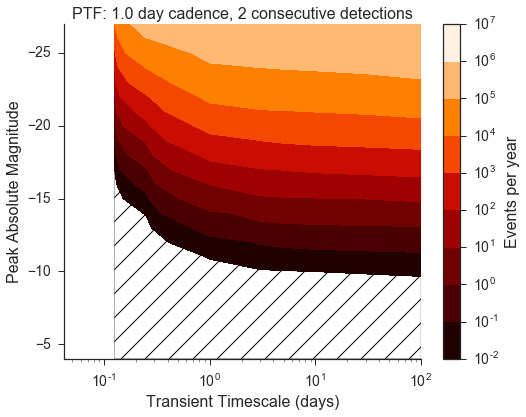

In [17]:
# Figure 8
plot_cadence_sensitivity(PTF,1,k_consecutive=2)

In [47]:
# store data for figure 9
# high-resolution for M=-19 only
survey = ZTF
t_cad = 1./24.
k_consecutive = 2
abs_mags = N.array([-19])
decay_timescales = N.logspace(-2,2,100) # days/mag
n_events = n_transients_per_year(survey, abs_mags, decay_timescales, t_cad, k_consecutive=k_consecutive)

shelf_name = 'fig/M-19_cadence_sensitivity_{}_{:.2f}_{}.shlv'.format(survey.name,t_cad,k_consecutive)
shelf = shelve.open(shelf_name, flag='c',protocol=pickle.HIGHEST_PROTOCOL)
shelf['abs_mags'] = abs_mags
shelf['decay_timescales'] = decay_timescales
shelf['n_events'] = n_events
shelf.close()

-19 0.01 9.49511984459
-19 0.0109749876549 15.6347432707
-19 0.0120450354026 24.5216609096
-19 0.0132194114847 36.7908061484
-19 0.014508287785 53.0169842983
-19 0.0159228279334 73.6591520904
-19 0.0174752840001 99.0185848464
-19 0.0191791026167 129.214223581
-19 0.0210490414451 164.183476742
-19 0.0231012970008 203.694613374
-19 0.0253536449397 247.377663779
-19 0.0278255940221 294.756622313
-19 0.0305385550883 345.295606873
-19 0.0335160265094 398.427781509
-19 0.0367837977183 453.591175783
-19 0.040370172586 510.259034289
-19 0.0443062145758 567.922491178
-19 0.0486260158007 626.110628848
-19 0.0533669923121 684.723276688
-19 0.0585702081806 743.273842997
-19 0.0642807311728 801.506354086
-19 0.0705480231072 859.329843912
-19 0.0774263682681 916.732126135
-19 0.0849753435909 973.652503335
-19 0.0932603346883 1030.07893383
-19 0.10235310219 1086.10586859
-19 0.112332403298 1141.57571342
-19 0.123284673944 1196.68248843
-19 0.135304777458 1251.40419807
-19 0.148496826225 1305.67112937

In [26]:
# plot function for figure 9
def compare_cadence_sensitivities(surveys,t_cads, abs_mag = -19, k_consecutive=2, plotdir='./fig'):

    fig = plt.figure()
    ax = plt.subplot(111)
    
    for survey, t_cad in zip(surveys,t_cads):
        shelf_name = 'fig/M-19_cadence_sensitivity_{}_{:.2f}_{}.shlv'.format(survey.name,t_cad,k_consecutive)
        shelf = shelve.open(shelf_name,protocol=pickle.HIGHEST_PROTOCOL)
        abs_mags = shelf['abs_mags'] 
        decay_timescales = shelf['decay_timescales']
        n_events  = shelf['n_events'] 
        shelf.close()
        w = abs_mags == abs_mag
        n = n_events[w,:]
        if t_cad == 1./24:
            cad_str = '1 hour'
        if t_cad == 1.:
            cad_str = '1 day'
        label = '{}, {} cadence'.format(survey.name,cad_str)
        plt.plot(decay_timescales,n[0],label=label)

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Transient Timescale (days)')
    plt.ylabel('Number of Events Per Year')
    #plt.xlim(1./24.,100)
    plt.ylim(1e-2,1e4)
    sb.despine(ax=ax)
    outside_legend()
    plt.savefig(plotdir+'cadence_comp.pdf',bbox_inches='tight')

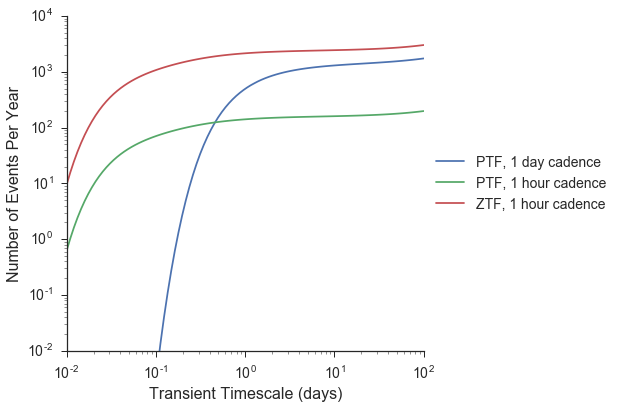

In [27]:
# FIGURE 9
compare_cadence_sensitivities([PTF,PTF,ZTF],[1,1./24,1./24])

In [ ]:
# store data for Figures 10 and 11 
# detections by cadences
use = ['ZTF','PS1','CRTS-2','DECam','LSST','HSC','Evryscope','ATLAS','ASAS-SN 1']
use_surveys = [s for s in surveys if s.name in use]

k_consecutive = 2
abs_mags = N.array([-19])
decay_timescales = N.array([20]) # days/mag
#cadences_days = N.array([1./24.,3./24.,6./24.,1., 3., 5., 10., 30.,100.])
cadences_days = N.logspace(-2,2,50) # days/mag

n_events = {}
for survey in use_surveys:
    ne = []
    for t_cad in cadences_days:
        ne.append(n_transients_per_year(survey, abs_mags, decay_timescales, t_cad, k_consecutive=k_consecutive))
    n_events[survey.name] = ne

shelf_name = 'fig/nevents_allsurveys_{:.1f}_{:.1f}_{}.shlv'.format(abs_mags[0],decay_timescales[0],k_consecutive)
shelf = shelve.open(shelf_name, flag='c',protocol=pickle.HIGHEST_PROTOCOL)
shelf['abs_mags'] = abs_mags
shelf['decay_timescales'] = decay_timescales
shelf['n_events'] = n_events
shelf['cadences_days'] = cadences_days
shelf['k_consecutive'] = k_consecutive

shelf.close()

In [21]:
# plotting code for Figures 10 and 11
def plot_nevents_bycadence(abs_mag=-19,decay_timescale=20, k_consecutive=2, plotdir='./'):

    use = ['ZTF','PS1','CRTS-2','DECam','LSST','HSC','Evryscope','ATLAS','ASAS-SN 1']
    use_surveys = [s for s in surveys if s.name in use]
    
    shelf_name = 'fig/nevents_allsurveys_{:.1f}_{:.1f}_{}.shlv'.format(abs_mag,decay_timescale,k_consecutive)
    shelf = shelve.open(shelf_name,protocol=pickle.HIGHEST_PROTOCOL)
    abs_mags = shelf['abs_mags'] 
    decay_timescales = shelf['decay_timescales']
    n_events  = shelf['n_events'] 
    cadences_days = shelf['cadences_days']

    shelf.close()

    for s in use_surveys:
        n = n_events[s.name]
        n = [ni[0] for ni in n]
        #plt.plot(cadences_days,n,label=s.name, color=s.color)
        plt.plot(cadences_days,n,label=s.name, color=s.color)


    plt.xlabel('Cadence (days)')
    plt.ylabel('Number of Events')
    plt.xlim(cadences_days.min(),cadences_days.max())
    plt.xscale('log')
    plt.yscale('log')
    sb.despine()
    outside_legend()
    plt.savefig(plotdir+shelf_name.replace('shlv','pdf'),bbox_inches='tight')


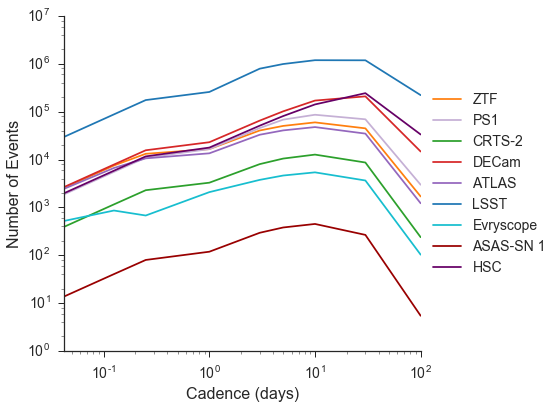

In [23]:
# FIGURE 10
plot_nevents_bycadence(plotdir=plot_dirnofig)

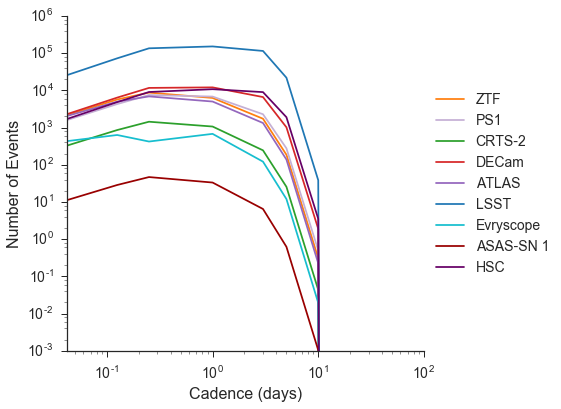

In [24]:
#FIGURE 11
plot_nevents_bycadence(decay_timescale=1,plotdir=plot_dirnofig)